# Проект-навыки по аналитике данных #

## Задание 1. A/B–тестирование ##

### 1.1 Условие ###

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные ###

В качестве входных данных вы имеете 4 csv-файла:

**groups.csv** – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа).

**groups_add.csv** – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных.

**active_studs.csv** – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.

**checks.csv** – файл с информацией об оплатах пользователей в дни проведения эксперимента.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import requests
from io import StringIO
from scipy.stats import normaltest, mannwhitneyu

**Я оценил сразу все задачи проекта и решил с самого начала прописывать действия в виде функций, так как они пригодятся в задании №3 :)**

**Надеюсь, Вы не посчитаете это за ошибку, так как я не вижу смысла два раза прописывать различные способы загрузки данных в Google Colab. Я могу перечислить, каким еще образом я мог бы начать первое задание:**
- **скачать файлы, импортировать их в файлы Google Colab и прочитать через pd.read_csv();**
- **скачать файлы, импортировать их на свой Google Drive, подключиться к диску и прочитать файлы через pd.read_csv().**

**Но я решил сразу пойти по трудному пути и реализовать все необходимые действия в виде функций, чтобы облегчить себе написание задания №3 в будущем!**

In [ ]:
def load_groups_add_from_yandex_disk(public_url, separator=';'):
    """
    Загрузка данных из файла на Яндекс.Диске.
    """
    try:
        # Публичная ссылка
        base_url = "https://cloud-api.yandex.net/v1/disk/public/resources/download?"
        # Формирование полной ссылки
        full_url = f"{base_url}public_key={public_url}"
        response = requests.get(full_url)
        if response.status_code != 200:
            raise Exception("Не удалось получить ссылку для скачивания.")

        download_url = response.json().get("href")
        if not download_url:
            raise Exception("Ссылка для скачивания не найдена.")

        file_response = requests.get(download_url)
        file_response.raise_for_status()
        csv_data = StringIO(file_response.text)
        df = pd.read_csv(csv_data, sep=separator)
        return df

    except Exception as e:
        print(f"Ошибка при загрузке файла: {e}")
        return None

In [ ]:
# Ссылки на файлы с данными
groups_href = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
active_studs_href = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_href = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

# Создание датафреймов из данных с помощью реализованной функции
groups = load_groups_add_from_yandex_disk(groups_href)
active_studs = load_groups_add_from_yandex_disk(active_studs_href)
checks = load_groups_add_from_yandex_disk(checks_href)

In [ ]:
print(f"\033[1mgroups:\033[0m\n{groups.head()}\n")
print(f"\033[1mactive_studs:\033[0m\n{active_studs.head()}\n")
print(f"\033[1mchecks:\033[0m\n{checks.head()}\n")

groups:
     id grp
0  1489   B
1  1627   A
2  1768   B
3  1783   B
4  1794   A

active_studs:
   student_id
0      581585
1     5723133
2     3276743
3     4238589
4     4475369

checks:
   student_id    rev
0        1627  990.0
1        3185  690.0
2       25973  690.0
3       26280  690.0
4      100300  990.0



**Проведем EDA:**

In [ ]:
print("\033[1m----------------groups----------------\033[0m")
groups.info()
print("\n\033[1m----------------active_studs-------------\033[0m")
active_studs.info()
print("\n\033[1m----------------checks-------------------\033[0m")
checks.info()

----------------groups----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB

----------------active_studs-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB

----------------checks-------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 

In [ ]:
# Объединение в общий датафрейм для последующего анализа
def merge_df(groups, active_studs, checks):
  df = pd.merge(groups, active_studs, left_on='id', right_on='student_id', how='left')
  df = pd.merge(df, checks, left_on='student_id', right_on='student_id', how='left')
  return df

df = merge_df(groups, active_studs, checks)
df

,id,grp,student_id,rev
0,1489,B,NaN,NaN
1,1627,A,1627.0,990.0
2,1768,B,NaN,NaN
3,1783,B,NaN,NaN
4,1794,A,NaN,NaN
...,...,...,...,...
74479,5692459,B,NaN,NaN
74480,5692572,B,NaN,NaN
74481,5692865,B,NaN,NaN
74482,5693667,B,NaN,NaN


In [ ]:
def processing_users(df):
  # Кодируем активных пользователей в отдельную колонку
  df['is_active'] = df['student_id'].notna().astype(int)

  # Кодируем заплативших пользователей в отдельную колонку
  df['has_payment'] = df['rev'].notna().astype(int)

  # Переименовывыем столбцы rev и grp
  df = df.rename(columns={
      'grp':'group',
      'rev': 'revenue'})

  # Заполняем пропуски в revenue нулями
  df['revenue'] = df['revenue'].fillna(0)

  # Удаляем столбец student_id, так как мы отметили активных студентов в
  # столбце is_active и в столбце student_id уже нет необходимости.
  df = df.drop(columns=['student_id'])

  return df

df = processing_users(df)
df

,id,group,revenue,is_active,has_payment
0,1489,B,0.0,0,0
1,1627,A,990.0,1,1
2,1768,B,0.0,0,0
3,1783,B,0.0,0,0
4,1794,A,0.0,0,0
...,...,...,...,...,...
74479,5692459,B,0.0,0,0
74480,5692572,B,0.0,0,0
74481,5692865,B,0.0,0,0
74482,5693667,B,0.0,0,0


In [ ]:
# Проверяем наличие пропусков
df.isna().sum()

,0
id,0
group,0
revenue,0
is_active,0
has_payment,0


### Описание данных

       Название столца    | Тип переменной              |                      Описание
    ----------------------|-----------------------------|------------------------------------------------------
    id                    |   числовая (дискретная)     | Уникальный номер пользователя
    group                 | категориальная(номинальная) | Группа тестирования
    revenue               |   числовая (дискретная)     | Сумма оплаты
    is_active             |  категориальная(бинарная)   | Активный пользователь
    has_payment           |  категориальная(бинарная)   | Платящий пользователь

In [ ]:
df.describe()

,id,revenue,is_active,has_payment
count,7.448400e+04,74484.000000,74484.000000,74484.000000
mean,2.133752e+06,6.254954,0.111809,0.005249
std,1.531423e+06,104.875161,0.315134,0.072263
min,1.489000e+03,0.000000,0.000000,0.000000
25%,9.174980e+05,0.000000,0.000000,0.000000
50%,1.667190e+06,0.000000,0.000000,0.000000
75%,3.322955e+06,0.000000,0.000000,0.000000
max,5.694419e+06,4650.000000,1.000000,1.000000


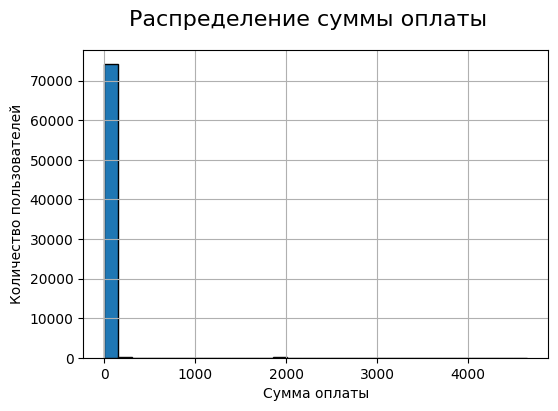

In [ ]:
df['revenue'].hist(figsize=(6, 4), bins=30, edgecolor='black')
plt.xlabel('Сумма оплаты')
plt.ylabel('Количество пользователей')
plt.suptitle("Распределение суммы оплаты", fontsize=16)
plt.show()

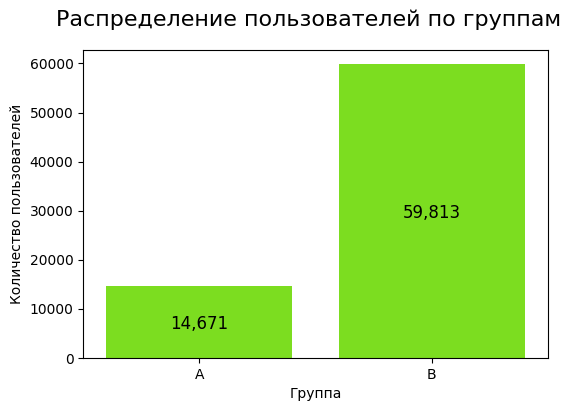

In [ ]:
# График зависимости между группой и количеством пользователей в ней
df_group = df.groupby('group').agg({'id': 'count'}).reset_index()
df_group.columns = ['group', 'count']

plt.figure(figsize=(6, 4))

ax = sns.barplot(data=df_group, x='group', y='count', color='lawngreen')

# Добавляем подписи значений над столбиками
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2.,  # X-координата текста (центр столбика)
        p.get_height() / 2.,             # Y-координата текста (середина столбика)
        f'{int(p.get_height()):,}',      # Текст (значение столбика с разделителями)
        ha='center',                     # Горизонтальное выравнивание (центр)
        va='center_baseline',            # Вертикальное выравнивание (центр)
        fontsize=12
    )

plt.xlabel('Группа')
plt.ylabel('Количество пользователей')
plt.suptitle("Распределение пользователей по группам", fontsize=16)
plt.show();

### **Метрики**
**На какие метрики вы смотрите в ходе анализа и почему?**
- Процент активных пользователей
- Средний доход на пользователя (ARPU)
- Средний доход на платящего пользователя (ARPPU)
- Конверсия в оплату (CR)
- Общая выручка

**Я смотрю на эти метрики, потому что:**
1. Всегда необходимо следить за активными пользователями, они приносят наибольший доход. По ним явно можно понять, ухудшился ли продукт. Поэтому необходимо увеличивать количество активных пользователей;
2. ARPU очень важна при оценке новой механики оплаты усоуг, так как если пользователям удобно оплачивать услуги и у них не возникает сложностей, то на этапе оплаты средний доход у пользователя будет увеличиваться;
3. ARPPU также важна, так как мы наблюдаем за средним доходом именно платящего пользователя. Если ARPU и ARPPU сильно различаются, значит многие пользователи не доходят до этапа оплаты, следовательно, необходимо разбираться на более ранних этапах;
4. Данная метрика тоже важна, по ней можно увидеть, какая часть пользователей платит за наши услуги. Если она довольно низкая, значит у нас есть проблемы на более ранних этапах и наши услуги не удовлетворяют потребности пользователей;
5. Общая выручка необходима для того, чтобы понимать, насколько больше/меньше денег мы заработали после введения новых механик оплаты. Эта метрика больше показательная - для общего понимания.

In [ ]:
# Процент активных пользователей
def percent_active_users(df):
  percent = '1. '
  result = df.groupby('group').agg({'is_active': 'mean'}).reset_index()
  for gr, res in zip(result['group'], result['is_active']):
    percent = percent + f'Процент активных пользователей в группе {gr}: {round(res * 100, 2)}%\n   '
  return print(percent)

# Средний доход на пользователя (ARPU)
def arpu(df):
  arpu = '2. '
  result = df.groupby('group').agg({'revenue': 'mean'}).reset_index()
  for gr, res in zip(result['group'], result['revenue']):
    arpu = arpu + f'Средний доход на пользователя в группе {gr}: {round(res, 2)} руб.\n   '
  return print(arpu)

# Средний доход на платящего пользователя (ARPPU)
def arppu(df):
  arppu = '3. '
  result = df.groupby('group').agg({'revenue':'sum', 'has_payment':'sum'}).reset_index()
  result['ARPPU'] = result['revenue'] / result['has_payment']

  # На случай, если будет 0 платящих пользователей
  result['ARPPU'] = result['ARPPU'].fillna(0)

  for gr, res in zip(result['group'], result['ARPPU']):
    arppu = arppu + f'Средний доход на платящего пользователя в группе {gr}: {round(res, 2)} руб.\n   '
  return print(arppu)

# Конверсия в оплату (CR)
def cr(df):
  cr = '4. '
  result = df.groupby('group').agg({'has_payment': 'mean'}).reset_index()
  for gr, res in zip(result['group'], result['has_payment']):
    cr = cr + f'Конверсия в оплату в группе {gr}: {round(res * 100, 2)}%\n   '
  return print(cr)

# Общий доход
def total_revenue(df):
  total_revenue = '5. '
  result = df.groupby('group').agg({'revenue': 'sum'}).reset_index()
  for gr, res in zip(result['group'], result['revenue']):
    total_revenue = total_revenue + f'Общий доход в группе {gr}: {round(res, 2)} руб.\n   '
  return print(total_revenue)

# Рассчет метрик
percent_active_users(df)
arpu(df)
arppu(df)
cr(df)
total_revenue(df)

1. Процент активных пользователей в группе A: 10.46%
   Процент активных пользователей в группе B: 11.36%
   
2. Средний доход на пользователя в группе A: 4.96 руб.
   Средний доход на пользователя в группе B: 6.57 руб.
   
3. Средний доход на платящего пользователя в группе A: 933.59 руб.
   Средний доход на платящего пользователя в группе B: 1255.83 руб.
   
4. Конверсия в оплату в группе A: 0.53%
   Конверсия в оплату в группе B: 0.52%
   
5. Общий доход в группе A: 72820.0 руб.
   Общий доход в группе B: 393074.0 руб.
   


**Имеются ли различия в показателях и с чем они могут быть связаны?**

**Да, различия имеются:**
1. Процент активных пользователей в целевой группе (В) вырос на 0.9%. Это может быть связано с тем, что часть пользователей узнали о новой механике оплаты и стали чаще заходить на сайт;
2. Средний доход на пользователя тоже вырос на 1.6 рубль - это может быть следствием увеличения активных пользователей - они начали оплачивать услуги;
3. Средний доход на платящего пользователя также увеличился на 322 руб., а это может быть связано с тем, что постоянным пользователям нравится новая механика оплаты и они оплачивают больше услуг;
4. Конверсия в оплату уменьшилась на 0.01%. Значение данной метрики крайне низкое, так как она всего 0.5% из 100%. Данный аспект может быть связан с проблемами в других этапах продукта, которые пользователь проходит до оплаты услуги;
5. Общий доход стал больше из-за того, что новые активные пользователи стали оплачивать услуги.

In [ ]:
# Создаем датасеты, разделенные по группам тестирования
df_group_a = df.loc[df.group == 'A']
df_group_b = df.loc[df.group == 'B']
df_group_a.head()

,id,group,revenue,is_active,has_payment
1,1627,A,990.0,1,1
4,1794,A,0.0,0,0
7,2067,A,0.0,0,0
8,2078,A,0.0,0,0
11,2213,A,0.0,0,0


In [ ]:
# Расчет необходимых характеристик

mean_revenue_a = df_group_a.revenue.mean()
mean_revenue_b = df_group_b.revenue.mean()
print(f"Среднее значение дохода на пользователя группы А: {mean_revenue_a}")
print(f"Среднее значение дохода на пользователя группы B: {mean_revenue_b}")
print()

var_revenue_a = df_group_a.revenue.var()
var_revenue_b = df_group_b.revenue.var()
print(f"Дисперсия дохода на пользователя группы А: {var_revenue_a:.2f}")
print(f"Дисперсия дохода на пользователя группы B: {var_revenue_b:.2f}")
print()

std_revenue_a = df_group_a.revenue.std()
std_revenue_b = df_group_b.revenue.std()
print(f"Среднеквадратичное отклонение дохода на пользователя группы А: {std_revenue_a:.2f}")
print(f"Среднеквадратичное отклонение дохода на пользователя группы B: {std_revenue_b:.2f}")

Среднее значение дохода на пользователя группы А: 4.963533501465476
Среднее значение дохода на пользователя группы B: 6.571715237490179

Дисперсия дохода на пользователя группы А: 9051.52
Дисперсия дохода на пользователя группы B: 11476.08

Среднеквадратичное отклонение дохода на пользователя группы А: 95.14
Среднеквадратичное отклонение дохода на пользователя группы B: 107.13


In [ ]:
# Проверим выборки на нормальность
print('Нормальность распределения для группы А: ', normaltest(df_group_a.revenue))
print('Нормальность распределения для группы В: ', normaltest(df_group_b.revenue))

Нормальность распределения для группы А:  NormaltestResult(statistic=np.float64(36506.31451921731), pvalue=np.float64(0.0))
Нормальность распределения для группы В:  NormaltestResult(statistic=np.float64(127134.25297800459), pvalue=np.float64(0.0))


**Для обеих групп p-value = 0, что говорит о ненормальности данных.**

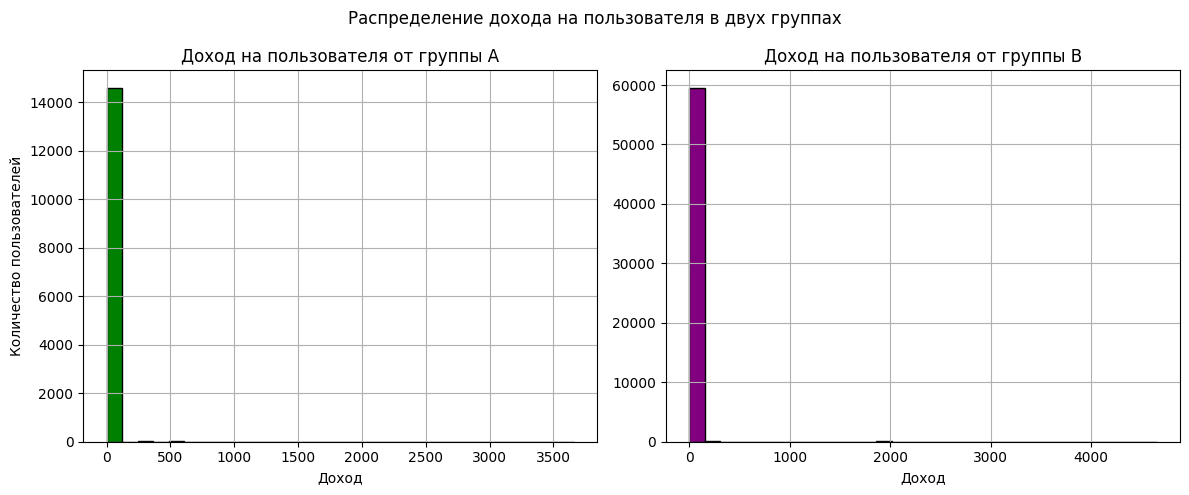

In [ ]:
# Нарисуем графики распредления, чтобы увидеть ненормальность

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(df_group_a.revenue, color='green', bins=30, edgecolor='black')
ax1.set_title('Доход на пользователя от группы А')
ax1.set_xlabel('Доход')
ax1.set_ylabel('Количество пользователей')
ax1.grid(True)

ax2.hist(df_group_b.revenue, color='purple', bins=30, edgecolor='black')
ax2.set_title('Доход на пользователя от группы В')
ax2.set_xlabel('Доход')
ax2.grid(True)

plt.suptitle('Распределение дохода на пользователя в двух группах')
plt.tight_layout()
plt.show();

Так как в наших данных:
- **неравные дисперсии;**
- **зависимые группы (заказы одного пользователя могут быть похожи друг на друга и иметь примерно одинаковую стоимость);**
- **ненормальное распредление выборок,**

то для тестирования гипотез необходимо выбирать непараметрический U-тест (тест Манна-Уитни). Хоть он и не учитывает, насколько сами значения больше или меньше других, но он работает именно с такими данными. Т-тест не подходит по причине ненормальности распределения данных.

Сформируем наши гипотезы:
- $H_0$: Распределения значений дохода на пользователя по всем характеристикам между группами одинаково.
- $H_1$: В какой-то из групп чаще встречаются более высокие значения, чем в другой.

In [ ]:
# Тест Манна-Уитни

stat, p_value = mannwhitneyu(df_group_a.revenue, df_group_b.revenue)
print('Statistics=%.2f, p=%.2f' % (stat, p_value))
alpha = 0.05
if p_value < alpha:
    print('Отклоняем нулевую гипотезу (Значимая разница между двумя группами)')
else:
    print('Не отклоняем нулевую гипотезу (Не значимая разница между двумя группами)')

Statistics=438791740.00, p=0.91
Не отклоняем нулевую гипотезу (Не значимая разница между двумя группами)


**Являются ли эти различия статистически значимыми?**

По результатам теста Манна-Уитни p_value > 0.05. Это значит, что нулевая гипотеза **не** отклоняется.
Таким образом:
- **различия статистически НЕ значимы;**
- **распределения значений дохода на пользователя между группами А и В одинаковы.**

**Стоит ли запускать новую механику на всех пользователей?**

Несмотря на **не** значимые статистические различия мой ответ -

**Да, стоит,** так как новая механика привела к небольшому приросту всех метрик, отвечающих за доход на пользователя. Если выкатить её на всех пользователей, они начнут больше оплачивать услуги и суммарный доход увеличится. Однако, над увеличением количества активных покупателей нашего сайта необходимо поработать.

## **Выводы по заданию 1**

Новая механика показала небольшие улучшения результатов по оплате улсуг, так как после её применения количество платящих пользователей не сильно увелечилось. Но конверсия в платящего пользователя медленно начала уменьшаться, а у нас и так до оплаты услуги доходит всего 0.5% наших пользователей, что критически мало.

**Это значит, что проблема нашего сайта таится на этапах еще до оплаты услуги. Необходимо более детально изучить все предыдущие этапы и выявить причину оттока пользователей.**

# Задание 2. SQL

## 2.1 Очень усердные ученики

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

Дана таблица **peas** с полями:

- st_id -	ID ученика
- timest -	Время решения карточки
- correct	-	Правильно ли решена горошина?
- subject	-	Дисциплина, в которой находится горошина

**Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов. Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.**

**Скрипт решения:**

```sql
SELECT COUNT(DISTINCT st_id)
  FROM
    (SELECT st_id FROM peas
      WHERE correct = true
        AND timest >= DATE_TRUNC('month', timest)
        AND timest < DATE_TRUNC('month', timest) + INTERVAL '1 month'
      GROUP BY st_id, date_trunc('month', timest)
     HAVING COUNT(*) >= 20
    ) as good_studs
```

**Вывод скрипта: 136 учеников.**

## 2.2 Оптимизация воронки

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Дана таблицы: **peas** (см. выше), **studs**:

- st_id	-	 ID ученика
- test_grp	-	 Метка ученика в данном эксперименте

и **final_project_check**:

- st_id	-	ID ученика
- sale_time	- Время покупки
- money	-	Цена, по которой приобрели данный курс
- subject	- Дисциплина

**Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:**

- **ARPU**
- **ARPAU**
- **CR в покупку**
- **СR активного пользователя в покупку**
- **CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике**
- **ARPU считается относительно всех пользователей, попавших в группы.**

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

**Скрипт решения:**

```sql
WITH enriched_students AS (
  SELECT s.st_id,
          s.test_grp,
          -- Флаг активного студента
          (SELECT COUNT(*) > 10
            FROM peas p
            WHERE p.st_id = s.st_id
              AND p.correct = TRUE) AS is_active,
          -- Флаг активного по математике
          (SELECT COUNT(*) >= 2
            FROM peas p
            WHERE p.st_id = s.st_id
              AND p.correct = TRUE
              AND p.subject = 'math') AS is_math_active,
          -- Сумма покупок
          (SELECT COALESCE(SUM(f.money), 0)
            FROM final_project_check f
            WHERE f.st_id = s.st_id) AS total_spent,
          -- Флаг покупки любого курса
          (SELECT EXISTS(
                      SELECT 1
                        FROM final_project_check f
                      WHERE f.st_id = s.st_id)
                        ) AS has_purchase,
          -- Флаг покупки курса по математике
          (SELECT EXISTS(
                      SELECT 1
                        FROM final_project_check f
                      WHERE f.st_id = s.st_id
                        AND f.subject = 'math')
                        ) AS has_math_purchase
   FROM
        (SELECT DISTINCT st_id, test_grp
           FROM studs) s
)

SELECT test_grp,
      -- ARPU
      SUM(total_spent) * 1.0 / COUNT(st_id) AS ARPU,
      
      -- ARPAU
      SUM(total_spent * is_active::int) * 1.0 / NULLIF(SUM(is_active::int), 0) AS ARPAU,
      
      -- CR в покупку
      SUM(has_purchase::int) * 100.0 / COUNT(st_id) AS CR_all,
      
      -- CR активного пользователя в покупку
      SUM((has_purchase AND is_active)::int) * 100.0 / NULLIF(SUM(is_active::int), 0) AS CR_active,
      
      -- CR из активности по математике в покупку курса по математике
      COALESCE(SUM((has_math_purchase AND is_math_active)::int) * 100.0
      / NULLIF(SUM(is_math_active::int), 0), 0) AS CR_math_active_to_math_purchase
FROM enriched_students
GROUP BY test_grp;
```

**Вывод скрипта:**

| test_grp  |      arpu |     arpau | cr_all | cr_active | cr_math_active_to_math_purchase |
|-----------|----------:|----------:|-------:|----------:|--------------------------------:|
| control   |  4,540.98 | 10,393.70 |   4.92 |     11.02 |                            0.00 |
| pilot     | 11,508.47 | 29,739.58 |  10.85 |     26.04 |                            0.00 |

# Задание 3. Python #
## 3.1 Задача ##

**1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv и на основании дополнительных параметров пересчитывать метрики.**

In [ ]:
groups_add_href = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'

def auto_process_metrics(add_href_df, metrics=False):

  # Загрузка и обработка данных
  groups_add = load_groups_add_from_yandex_disk(add_href_df, separator=',')
  result = pd.concat([groups, groups_add], axis = 0)
  result = merge_df(result, active_studs, checks)
  result = processing_users(result)

  # Пересчет метрик
  if metrics == True:
    percent_active_users(result)
    arpu(result)
    arppu(result)
    cr(result)
    total_revenue(result)

  return result

auto_process_metrics(groups_add_href, True)

1. Процент активных пользователей в группе A: 10.47%
   Процент активных пользователей в группе B: 11.36%
   
2. Средний доход на пользователя в группе A: 4.96 руб.
   Средний доход на пользователя в группе B: 6.6 руб.
   
3. Средний доход на платящего пользователя в группе A: 933.59 руб.
   Средний доход на платящего пользователя в группе B: 1257.88 руб.
   
4. Конверсия в оплату в группе A: 0.53%
   Конверсия в оплату в группе B: 0.52%
   
5. Общий доход в группе A: 72820.0 руб.
   Общий доход в группе B: 394974.0 руб.
   


,id,group,revenue,is_active,has_payment
0,1489,B,0.0,0,0
1,1627,A,990.0,1,1
2,1768,B,0.0,0,0
3,1783,B,0.0,0,0
4,1794,A,0.0,0,0
...,...,...,...,...,...
74571,200247820,B,0.0,0,0
74572,201032527,B,0.0,0,0
74573,201067612,B,0.0,0,0
74574,201067653,B,0.0,0,0


После добавления информации из дополнительного файла у нас добавилось 92 новых пользователя, однако, на метрики это практически не повлияло, так как средний доход на пользователя в группе B поднялся всего на 30 копеек, а средний доход на платящего пользователя в группе B на 2 рубля.

**2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.**

Подобрал красивые цвета:)

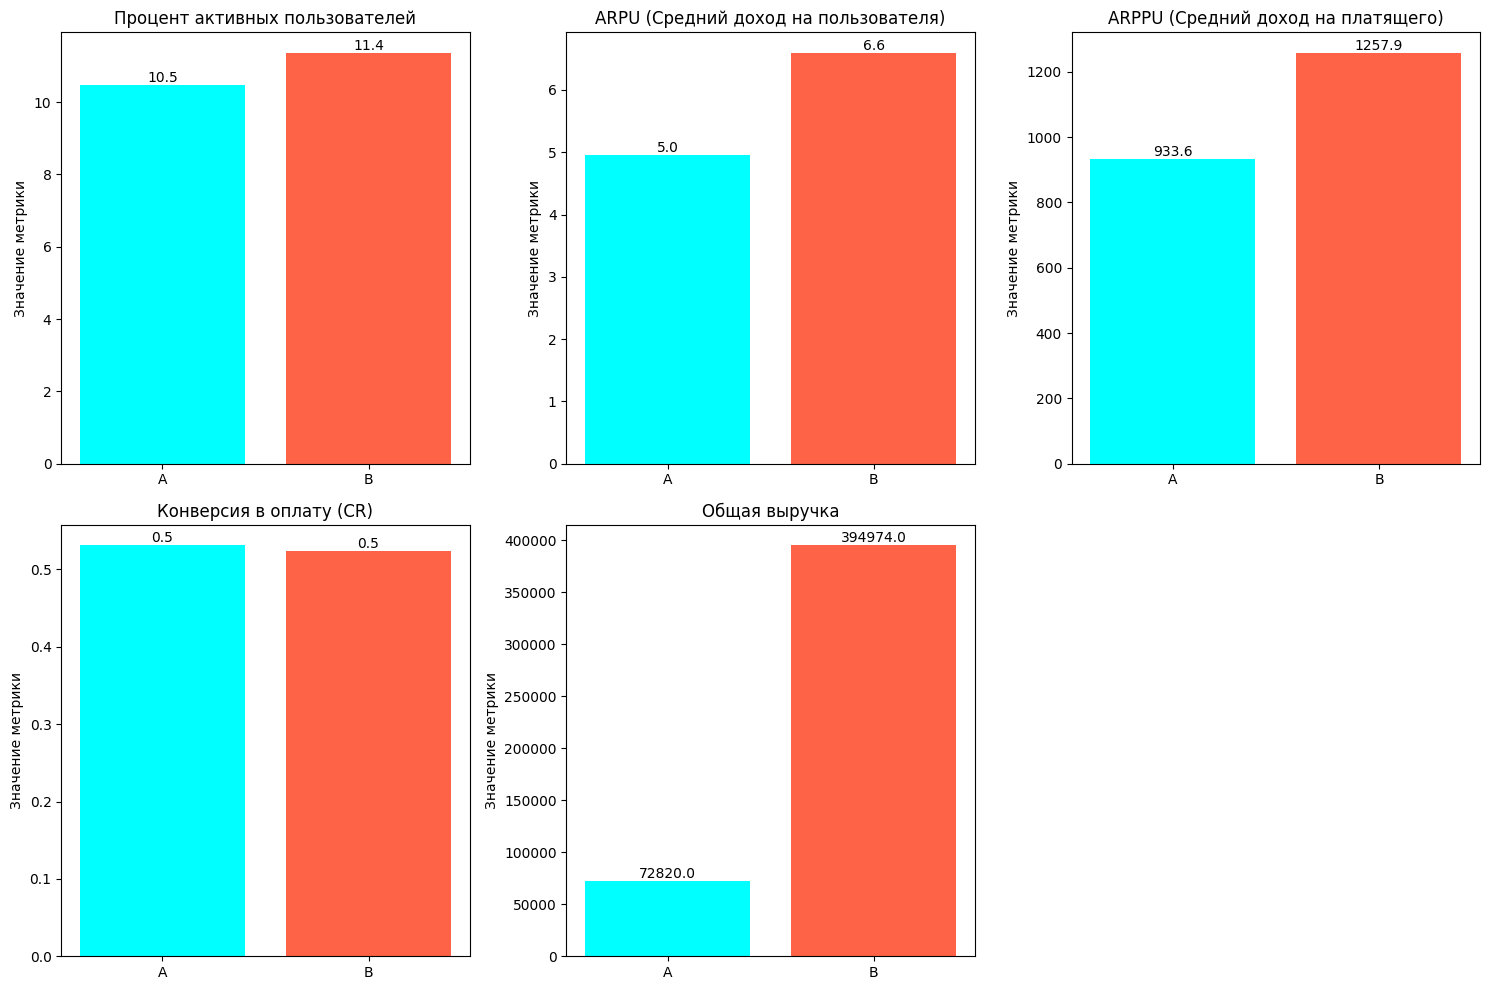

In [ ]:
def plot_metrics_comparison(df):

    group_a = df[df['group'] == 'A']
    group_b = df[df['group'] == 'B']

    # Расчет метрик
    metrics = {
        'Процент активных пользователей': {
            'A': group_a['is_active'].mean() * 100,
            'B': group_b['is_active'].mean() * 100
        },
        'ARPU (Средний доход на пользователя)': {
            'A': group_a['revenue'].mean(),
            'B': group_b['revenue'].mean()
        },
        'ARPPU (Средний доход на платящего)': {
            'A': group_a[group_a['revenue'] > 0]['revenue'].mean(),
            'B': group_b[group_b['revenue'] > 0]['revenue'].mean()
        },
        'Конверсия в оплату (CR)': {
            'A': group_a['has_payment'].mean() * 100,
            'B': group_b['has_payment'].mean() * 100
        },
        'Общая выручка': {
            'A': group_a['revenue'].sum(),
            'B': group_b['revenue'].sum()
        }
    }

    plt.figure(figsize=(15, 10))

    # Построение графиков для каждой метрики
    for i, (metric_name, values) in enumerate(metrics.items(), 1):
        plt.subplot(2, 3, i)
        groups = ['A', 'B']
        metric_values = [values['A'], values['B']]
        bars = plt.bar(groups, metric_values, color=['aqua', 'tomato'])
        plt.grid(False)

        # Добавление значений на столбцы
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2., height,
                    f'{height:.1f}',
                    ha='center', va='bottom')

        plt.title(metric_name)
        plt.ylabel('Значение метрики')

    plt.tight_layout()
    plt.show()

# Без вывода метрик
result_df = auto_process_metrics(groups_add_href, False)
plot_metrics_comparison(result_df)

## **Выводы по заданию 3**

Была написана удобная функция для автоматической подгрузки новых данных и расчета метрик по ним, а также визуализация данных метрик. Это позволит быстро оценить метрики на поступивших данных, не тратя лишнее время.

# ИТОГ

**Проанализировав все данные, изучив их распределения и нормальность, посмотрев на необходимые метрики и ихизменение спустя несколько дней можно сделать следующие выводы:**

- Самое главное то, что проблема нашего сайта заключается не в механике оплаты услуг, а на предыдущих этапах. Так как активные пользователи исправно оплачивают услуги, при этом многие пользователи попросту не доходят до оплаты;

- При поиске различий в показателях не было обнаружено статистически значимых различий;

- Новая механика практически не повлияла на метрики, потому что значения увечились не более чем на 1% по всем основным метрикам. Однако, предлагается выкатить новую механику оплаты по той причине, что метрики увеличиваются. Если разобраться в предыдущих этапах и пользователи начнут доходить до этапа оплаты, то с большей долей вероятности с новой механикой метрики будут расти намного быстрее, чем без неё.


**Далее необходимо:**

- Изучить, на каких этапах пользователи уходят с сайта;

- Провести A/B-тесты для улучшения проблемных этапов;

- Запустить повторный тест после улучшения проблемных этапов, чтобы оценить реальный эффект новой механики;

- Добавить отслеживание LTV (Lifetime Value) и Retention Rate, чтобы оценить долгосрочное влияние изменений.

